In [1]:
import pandas as pd
import numpy as np
import ruptures as rp
from prediction_pipeline.preprocessing import *
from sklearn.linear_model import LinearRegression
from glob import glob
%load_ext autoreload
%autoreload 2

from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.cross_decomposition import PLSRegression
from collections import defaultdict 
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.model_selection import RepeatedStratifiedKFold
from scipy.linalg import cholesky

from pygam import LinearGAM, s, f, te

/home/hv270/platelets/lib/python3.7/site-packages/FlowCytometryTools/core/docstring.py:56: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  doc = dedent(doc)


In [2]:
data_dir = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/data_home"
pheno_cols = ["ADP_PSEL","ADP_FIB","ADP",
               "CRP_PSEL","CRP_FIB","CRP",
               "TRAP_PSEL","TRAP_FIB","TRAP",
               "PAR1_PSEL","PAR1_FIB","PAR1",
               "PAR4_PSEL","PAR4_FIB","PAR4"]

cholesky_adj = False
adj_by_cohorts = False # Pas la même distribution d'âge/sexe dans les cohortes
adjust_at_all = False

In [3]:
all_features_cols = pd.read_hdf("%s/processed/features.hdf" % data_dir).columns
#features_cols = ['median_0', 'iqr_0','median_1','iqr_1']
features_cols = all_features_cols
covar_cols = ["IPF","PLT","MPV","PCT","PDW","SEX","AGE"] + ["PC%d" % d for d in range(1,11)]

In [4]:
# Try very simple :
# - GWAS cleaned features
# - 3 purple points to see if they look suspicious
# - collider effect ?
# GWAS to slack
# 

# Load tables

In [6]:
X_all = pd.read_csv("%s/processed/X_all.csv" % data_dir,index_col=0)
X_all = X_all.loc[X_all.AGE <75]
#X_all = X_all.loc[X_all.Instrument != 0] Machine 0 yields bad correlations
X_all = X_all.loc[~(X_all.PC1.isnull() & X_all.index.str.contains("INT"))]
cohort_size = X_all.cohort.value_counts()
good_cohorts = cohort_size.loc[cohort_size > 200].index.tolist()
X_all = X_all.loc[X_all.cohort.isin(good_cohorts)]
X_all.shape

(26349, 54)

In [7]:
X_all = X_all.rename(columns={"days_since_start_y":"days_since_start"})
del X_all["days_since_start_x"]

In [8]:
X_all.sample(5)

SEX   AGE        PLT       MPV       PDW       PCT       IPF  \
SampleNo                                                                        
INT_116_882200     2  42.6  -2.004386  0.580506  0.991221  0.011580  0.013528   
INT_116_4609100    1  70.1  13.547055 -0.305479  0.025874  0.025726 -0.142311   
INT_116_3125500    2  39.6  17.015829  0.482767  1.027569  0.033131  0.141663   
INT_116_3130900    2  53.0 -61.170575  1.353906  3.913295 -0.043461  0.318405   
INT_116_701000     1  50.5 -21.844727  0.720140  0.895676  0.003018  0.162550   

                 cohort  median_0  median_1  ...       PC3       PC4  \
SampleNo                                     ...                       
INT_116_882200       18  0.595240  0.701766  ...  0.005128 -0.004599   
INT_116_4609100       5 -0.489595  0.963873  ...  0.008338 -0.001492   
INT_116_3125500      37  1.054476  0.147587  ...  0.000548 -0.001752   
INT_116_3130900      17  1.766600 -0.167724  ... -0.002332 -0.005308   
INT_116_701000       37  1.361230  0.654893  ... -0.006743 -0.001916   

                      PC5       PC6       PC7       PC8       PC9      PC10  \
SampleNo                                                                      
INT_116_882200  -0.002205 -0.004472  0.006689  0.004933 -0.001468  0.010080   
INT_116_4609100  0.008781 -0.000113  0.002819  0.009837 -0.002623 -0.001447   
INT_116_3125500 -0.004402  0.005650 -0.008823  0.003442 -0.001076  0.000276   
INT_116_3130900 -0.006781  0.002763 -0.003748  0.009113  0.010336 -0.002228   
INT_116_701000  -0.003649 -0.002667  0.001154  0.006166 -0.009177 -0.004604   

                 Instrument  days_since_start  
SampleNo                                       
INT_116_882200            1               640  
INT_116_4609100           1                 1  
INT_116_3125500           0               574  
INT_116_3130900           1               578  
INT_116_701000            0               593  

[5 rows x 53 columns]

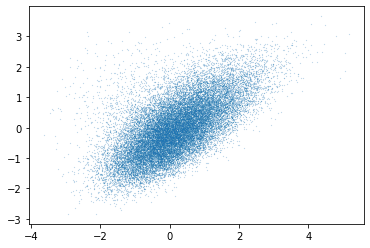

In [9]:
plt.scatter(X_all["lower_0"],X_all["MPV"],s=.01)

In [11]:
for f in features_cols:
    print(f)
    print(pearsonr(X_all.loc[~X_all.PEAR1.isnull(),f],
         X_all.loc[~X_all.PEAR1.isnull(),"PEAR1"]))

median_0
(-0.0008645269410122381, 0.889344409288857)
median_1
(0.01797987272661374, 0.003805517238624956)
upper_0
(-0.01415046605999526, 0.022760083836656453)
upper_1
(0.008457176761138462, 0.17348484891264213)
lower_0
(0.007983101987924715, 0.19886513631690525)
lower_1
(0.021979452337184215, 0.00040359847067210667)
std_0
(-0.027841244838221275, 7.410765401938836e-06)
std_1
(-0.011135596986501215, 0.07310452291492153)
iqr_0
(-0.020140247036256033, 0.0011884985601144664)
iqr_1
(-0.022383225339217484, 0.0003148982646623269)
ratio_upper
(0.011753992347496809, 0.05852967719769514)
ratio_lower
(0.006547647434795881, 0.2919902485886914)
ratio_std
(0.024288622588802055, 9.248800757856858e-05)
std_2_high
(-0.017080458950093486, 0.0059765208917265085)
std_2_low
(0.004366210653042526, 0.48225193042087594)


# Adjust features by covariates

In [14]:
def correlate(X, cols1,cols2):
    C = (1./X.shape[0])*((X[cols1] - X[cols1].mean(axis=0))/X[cols1].std(axis=0)).T @ ((X[cols2] - X[cols2].mean(axis=0))/X[cols2].std(axis=0))
    return C

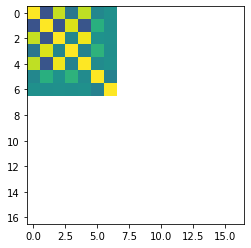

In [15]:
plt.imshow(correlate(X_all,covar_cols,covar_cols).values,vmin=-1,vmax=1)

In [16]:
def test_correlation_w_features(X,pheno="ADP"):
    cond = ~X[pheno].isnull()
    print("%d donors" % (cond.sum()))
    for c in features_cols:
        r, p = pearsonr(X.loc[cond,c],
                 X.loc[cond,pheno])
        print("%s   \t\t %.2f\t %.2f \t %.2e" % (c, r, r**2, p))

In [17]:
def adjust_cholesky(Q_ref,X,plot=False):
    Q = correlate(X, features_cols,features_cols)
    L = cholesky(Q)
    L_ref = cholesky(Q_ref)
    X_decorr = X.copy()
    X_decorr[features_cols] = X[features_cols] @ np.linalg.inv(L)

    X_recorr = X_decorr.copy()
    X_recorr[features_cols] = X_recorr[features_cols] @ L_ref
    if plot:
        plt.figure()
        for f in features_cols:
            plt.scatter(X[f],X_recorr[f],label=f)
        plt.legend()
    return X_recorr

In [18]:
covar_cols_for_adj = ["SEX","AGE","PLT","MPV","PDW","IPF","PCT"]
PFC = ~X_all.index.str.contains("INT_116")
INT = X_all.index.str.contains("INT_116")
print("%d train samples" % PFC.sum())
print("%d INTERVAL samples" % INT.sum())

584 train samples
25765 INTERVAL samples


In [19]:
print("Before adjustment # 1")
test_correlation_w_features(X_all.loc[PFC])

Before adjustment # 1
486 donors
median_0   		 0.16	 0.03 	 3.56e-04
median_1   		 -0.22	 0.05 	 9.20e-07
upper_0   		 0.15	 0.02 	 1.22e-03
upper_1   		 -0.15	 0.02 	 6.10e-04
lower_0   		 0.17	 0.03 	 1.68e-04
lower_1   		 -0.29	 0.08 	 7.95e-11
std_0   		 0.12	 0.01 	 9.79e-03
std_1   		 0.20	 0.04 	 8.60e-06
iqr_0   		 0.10	 0.01 	 3.34e-02
iqr_1   		 0.24	 0.06 	 1.11e-07
ratio_upper   		 -0.17	 0.03 	 2.56e-04
ratio_lower   		 0.01	 0.00 	 8.43e-01
ratio_std   		 -0.05	 0.00 	 3.16e-01
std_2_high   		 0.11	 0.01 	 1.88e-02
std_2_low   		 0.17	 0.03 	 1.83e-04


In [20]:
print("Before adjustment # 1")
test_correlation_w_features(X_all.loc[INT],pheno="PEAR1")

Before adjustment # 1
25765 donors
median_0   		 -0.00	 0.00 	 9.02e-01
median_1   		 0.02	 0.00 	 3.28e-03
upper_0   		 -0.01	 0.00 	 2.30e-02
upper_1   		 0.01	 0.00 	 1.64e-01
lower_0   		 0.01	 0.00 	 1.91e-01
lower_1   		 0.02	 0.00 	 3.95e-04
std_0   		 -0.03	 0.00 	 7.58e-06
std_1   		 -0.01	 0.00 	 7.45e-02
iqr_0   		 -0.02	 0.00 	 1.11e-03
iqr_1   		 -0.02	 0.00 	 3.51e-04
ratio_upper   		 0.01	 0.00 	 6.36e-02
ratio_lower   		 0.01	 0.00 	 2.75e-01
ratio_std   		 0.02	 0.00 	 9.90e-05
std_2_high   		 -0.02	 0.00 	 5.12e-03
std_2_low   		 0.00	 0.00 	 4.44e-01


In [21]:
test_correlation_w_features(X_all.loc[PFC],pheno="PEAR1")

138 donors
median_0   		 0.00	 0.00 	 9.70e-01
median_1   		 -0.04	 0.00 	 6.30e-01
upper_0   		 0.00	 0.00 	 9.80e-01
upper_1   		 -0.03	 0.00 	 7.42e-01
lower_0   		 0.01	 0.00 	 9.11e-01
lower_1   		 0.00	 0.00 	 9.54e-01
std_0   		 -0.01	 0.00 	 8.62e-01
std_1   		 -0.02	 0.00 	 8.32e-01
iqr_0   		 0.01	 0.00 	 9.38e-01
iqr_1   		 -0.05	 0.00 	 5.38e-01
ratio_upper   		 0.03	 0.00 	 6.94e-01
ratio_lower   		 -0.05	 0.00 	 5.42e-01
ratio_std   		 0.01	 0.00 	 9.11e-01
std_2_high   		 0.06	 0.00 	 4.74e-01
std_2_low   		 -0.11	 0.01 	 1.88e-01


In [22]:
covar_cols_for_adj

['SEX', 'AGE', 'PLT', 'MPV', 'PDW', 'IPF', 'PCT']

In [23]:
all_features_cols_unadjusted = ["%s_unadjusted" % f for f in all_features_cols]
features_cols_unadjusted = ["%s_unadjusted" % f for f in features_cols]
X_all[all_features_cols_unadjusted] = X_all[all_features_cols].copy()

In [24]:
if adjust_at_all:

    sub_X_adj = []

    for cohort, sub_X in X_all.groupby("cohort_all" if not adj_by_cohorts else "cohort"):
        #lm_cohort = PLSRegression(n_components=4).fit(sub_X_train[covar_cols_for_adj],sub_X_train[features_cols])
        lm_cohort = LinearRegression().fit(sub_X[covar_cols_for_adj],sub_X[all_features_cols_unadjusted])
        sub_X[all_features_cols] -= lm_cohort.predict(sub_X[covar_cols_for_adj])
        sub_X[all_features_cols] /= sub_X[all_features_cols].std()
        
        #for f in features_cols:
        #    sub_X[f] = np.clip(sub_X[f],
        #                     sub_X[f].median() - 3*sub_X[f].std(),
        #                     sub_X[f].median() + 3*sub_X[f].std())
        
        sub_X_adj.append(sub_X)
    
    X_adj = pd.concat(sub_X_adj,axis=0)
    print(X_adj.shape[0])
    X_all.loc[X_adj.index,all_features_cols] = X_adj[all_features_cols]
    
if adjust_at_all and adjust_cholesky:
    Q_ref = correlate(X_all,features_cols,features_cols)
    sub_X_adj = []
    for cohort, sub_X in X_all.loc[INT].groupby("cohort_all" if not adj_by_cohorts else "cohort"):
        if sub_X.shape[0] <= 30: continue
        sub_X_adj.append(adjust_cholesky(Q_ref,sub_X))
    X_adj = pd.concat(sub_X_adj,axis=0)
    print(X_adj.shape[0])
    X_all.loc[X_adj.index,features_cols] = X_adj[features_cols]

In [25]:
print("After adjustment # 1")
test_correlation_w_features(X_all.loc[PFC])

After adjustment # 1
486 donors
median_0   		 0.16	 0.03 	 3.56e-04
median_1   		 -0.22	 0.05 	 9.20e-07
upper_0   		 0.15	 0.02 	 1.22e-03
upper_1   		 -0.15	 0.02 	 6.10e-04
lower_0   		 0.17	 0.03 	 1.68e-04
lower_1   		 -0.29	 0.08 	 7.95e-11
std_0   		 0.12	 0.01 	 9.79e-03
std_1   		 0.20	 0.04 	 8.60e-06
iqr_0   		 0.10	 0.01 	 3.34e-02
iqr_1   		 0.24	 0.06 	 1.11e-07
ratio_upper   		 -0.17	 0.03 	 2.56e-04
ratio_lower   		 0.01	 0.00 	 8.43e-01
ratio_std   		 -0.05	 0.00 	 3.16e-01
std_2_high   		 0.11	 0.01 	 1.88e-02
std_2_low   		 0.17	 0.03 	 1.83e-04


In [26]:
test_correlation_w_features(X_all.loc[INT],pheno="PEAR1")

25765 donors
median_0   		 -0.00	 0.00 	 9.02e-01
median_1   		 0.02	 0.00 	 3.28e-03
upper_0   		 -0.01	 0.00 	 2.30e-02
upper_1   		 0.01	 0.00 	 1.64e-01
lower_0   		 0.01	 0.00 	 1.91e-01
lower_1   		 0.02	 0.00 	 3.95e-04
std_0   		 -0.03	 0.00 	 7.58e-06
std_1   		 -0.01	 0.00 	 7.45e-02
iqr_0   		 -0.02	 0.00 	 1.11e-03
iqr_1   		 -0.02	 0.00 	 3.51e-04
ratio_upper   		 0.01	 0.00 	 6.36e-02
ratio_lower   		 0.01	 0.00 	 2.75e-01
ratio_std   		 0.02	 0.00 	 9.90e-05
std_2_high   		 -0.02	 0.00 	 5.12e-03
std_2_low   		 0.00	 0.00 	 4.44e-01


In [27]:
def plot_snp(X,feature):
    fig = plt.figure(figsize=(6,3))
    i = 1
    for MAC, X_ in X.groupby("PEAR1"):
        ax = fig.add_subplot(3,1,i)
        ax.hist(X_[feature],density=True,range=(-2,2),histtype="step",bins=50,label="MAC = %d" % MAC)
        ax.axvline(X_[feature].mean(),c="red")
        i += 1
        plt.legend()

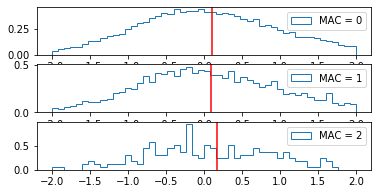

In [28]:
plot_snp(X_all.loc[INT],"median_0")

23633 good int samples (over 25765)
557 good train samples (over 584)


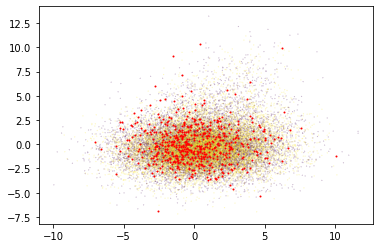

In [29]:
# Here we discard the weird spot
pca_train = PCA().fit(X_all.loc[PFC,features_cols])
pca_int = PCA().fit(X_all.loc[INT,features_cols])

X_t_train = pca_train.transform(X_all.loc[PFC,features_cols])
X_t_int   = pca_train.transform(X_all.loc[INT,features_cols])

max_norm = 6
plt.scatter(X_t_int  [:,0],X_t_int  [:,1],s=.01,c=X_all.loc[INT,"Instrument"])
plt.scatter(X_t_train[:,0],X_t_train[:,1],s=1,c="red")

pre_filtering_size = INT.sum()
pre_filtering_train_size = PFC.sum()
good_samples_int = X_all.loc[INT,features_cols].iloc[np.linalg.norm(X_t_int,axis=1) <= max_norm].index.tolist()
good_samples_pfc = X_all.loc[PFC,features_cols].iloc[np.linalg.norm(X_t_train,axis=1) <= max_norm].index.tolist()

print("%d good int samples (over %d)" % (len(good_samples_int),pre_filtering_size))
print("%d good train samples (over %d)" % (len(good_samples_pfc),pre_filtering_train_size))

In [30]:
PFC = ~X_all.index.str.contains("INT_116") & X_all.index.isin(good_samples_pfc)
INT = X_all.index.str.contains("INT_116") & X_all.index.isin(good_samples_int)
X_all = X_all.loc[PFC | INT]
PFC = ~X_all.index.str.contains("INT_116") & X_all.index.isin(good_samples_pfc)
INT = X_all.index.str.contains("INT_116") & X_all.index.isin(good_samples_int)
print("%d train samples" % PFC.sum())
print("%d INTERVAL samples" % INT.sum())

557 train samples
23633 INTERVAL samples


In [31]:
if adjust_at_all:

    sub_X_adj = []

    for cohort, sub_X in X_all.groupby("cohort_all" if not adj_by_cohorts else "cohort"):
        #lm_cohort = PLSRegression(n_components=4).fit(sub_X_train[covar_cols_for_adj],sub_X_train[features_cols])
        lm_cohort = LinearRegression().fit(sub_X[covar_cols_for_adj],sub_X[all_features_cols_unadjusted])
        sub_X[all_features_cols] -= lm_cohort.predict(sub_X[covar_cols_for_adj])
        sub_X[all_features_cols] /= sub_X[all_features_cols].std()
        
        #for f in features_cols:
        #    sub_X[f] = np.clip(sub_X[f],
        #                     sub_X[f].median() - 3*sub_X[f].std(),
        #                     sub_X[f].median() + 3*sub_X[f].std())
        
        sub_X_adj.append(sub_X)
    
    X_adj = pd.concat(sub_X_adj,axis=0)
    print(X_adj.shape[0])
    X_all.loc[X_adj.index,all_features_cols] = X_adj[all_features_cols]
    
if adjust_at_all and adjust_cholesky:
    Q_ref = correlate(X_all,features_cols,features_cols)
    sub_X_adj = []
    for cohort, sub_X in X_all.loc[INT].groupby("cohort_all" if not adj_by_cohorts else "cohort"):
        if sub_X.shape[0] <= 30: continue
        sub_X_adj.append(adjust_cholesky(Q_ref,sub_X))
    X_adj = pd.concat(sub_X_adj,axis=0)
    print(X_adj.shape[0])
    X_all.loc[X_adj.index,features_cols] = X_adj[features_cols]

In [32]:
print("After adjustment # 2")
test_correlation_w_features(X_all.loc[PFC],pheno="ADP")

After adjustment # 2
467 donors
median_0   		 0.15	 0.02 	 1.56e-03
median_1   		 -0.24	 0.06 	 1.02e-07
upper_0   		 0.14	 0.02 	 2.11e-03
upper_1   		 -0.18	 0.03 	 8.15e-05
lower_0   		 0.15	 0.02 	 1.55e-03
lower_1   		 -0.31	 0.10 	 3.74e-12
std_0   		 0.12	 0.01 	 8.59e-03
std_1   		 0.21	 0.05 	 3.41e-06
iqr_0   		 0.10	 0.01 	 2.95e-02
iqr_1   		 0.25	 0.06 	 5.52e-08
ratio_upper   		 -0.17	 0.03 	 3.06e-04
ratio_lower   		 0.02	 0.00 	 6.81e-01
ratio_std   		 -0.04	 0.00 	 3.41e-01
std_2_high   		 0.11	 0.01 	 1.65e-02
std_2_low   		 0.16	 0.03 	 4.83e-04


In [33]:
test_correlation_w_features(X_all.loc[INT],pheno="PEAR1")

23633 donors
median_0   		 0.01	 0.00 	 2.11e-01
median_1   		 0.02	 0.00 	 3.66e-04
upper_0   		 -0.01	 0.00 	 2.20e-01
upper_1   		 0.02	 0.00 	 1.94e-02
lower_0   		 0.02	 0.00 	 1.05e-02
lower_1   		 0.03	 0.00 	 8.46e-05
std_0   		 -0.03	 0.00 	 6.80e-05
std_1   		 -0.01	 0.00 	 2.20e-01
iqr_0   		 -0.02	 0.00 	 1.02e-02
iqr_1   		 -0.02	 0.00 	 2.59e-03
ratio_upper   		 0.01	 0.00 	 1.89e-01
ratio_lower   		 0.00	 0.00 	 7.65e-01
ratio_std   		 0.02	 0.00 	 3.74e-04
std_2_high   		 -0.02	 0.00 	 9.21e-03
std_2_low   		 0.01	 0.00 	 1.84e-01


In [34]:
test_correlation_w_features(X_all.loc[PFC],pheno="PEAR1")

133 donors
median_0   		 -0.03	 0.00 	 7.29e-01
median_1   		 -0.02	 0.00 	 7.93e-01
upper_0   		 -0.05	 0.00 	 5.96e-01
upper_1   		 -0.01	 0.00 	 8.98e-01
lower_0   		 -0.01	 0.00 	 8.71e-01
lower_1   		 0.03	 0.00 	 7.63e-01
std_0   		 -0.05	 0.00 	 5.47e-01
std_1   		 -0.02	 0.00 	 7.97e-01
iqr_0   		 -0.03	 0.00 	 7.31e-01
iqr_1   		 -0.06	 0.00 	 4.70e-01
ratio_upper   		 0.07	 0.00 	 4.57e-01
ratio_lower   		 -0.03	 0.00 	 7.52e-01
ratio_std   		 0.05	 0.00 	 5.89e-01
std_2_high   		 0.06	 0.00 	 5.08e-01
std_2_low   		 -0.11	 0.01 	 2.16e-01


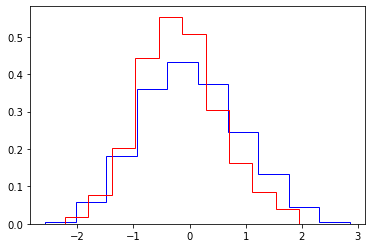

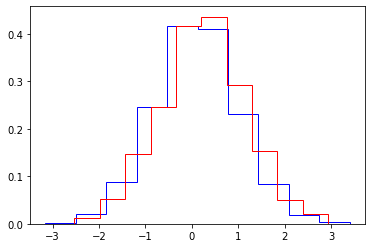

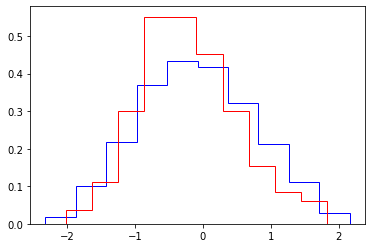

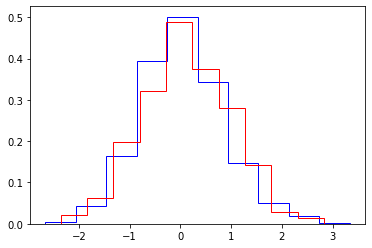

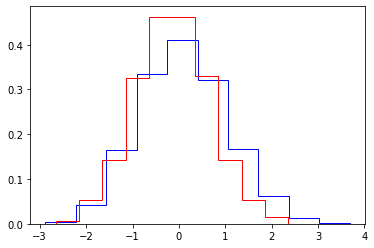

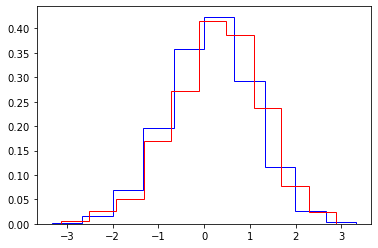

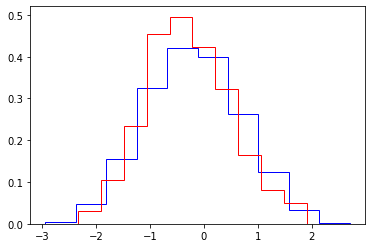

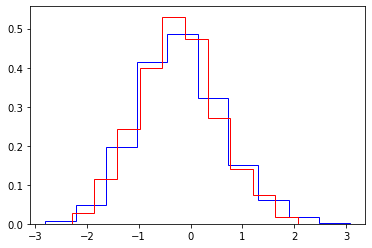

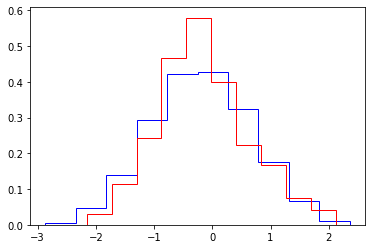

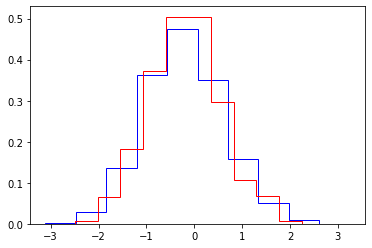

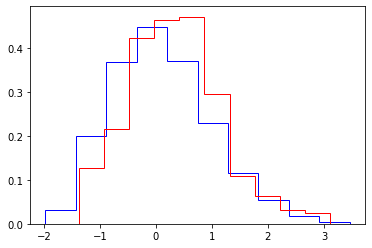

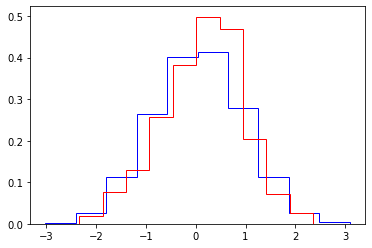

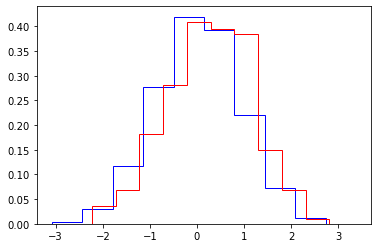

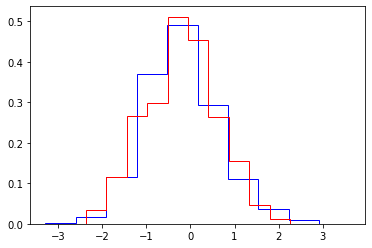

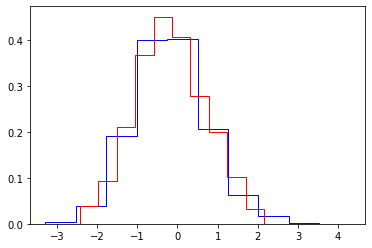

In [35]:
for f in features_cols:
    plt.figure()
    plt.hist(X_all.loc[INT,f],color="blue",histtype="step",density=True)
    plt.hist(X_all.loc[PFC,f],color="red",histtype="step",density=True)

23 BKPS
22 BKPS
3 BKPS


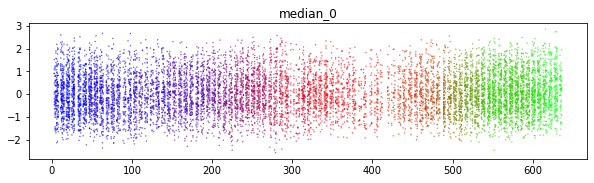

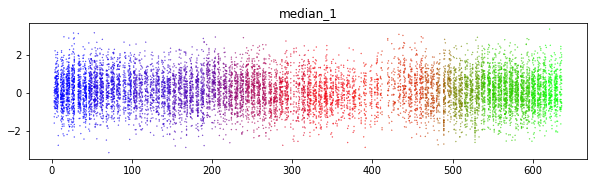

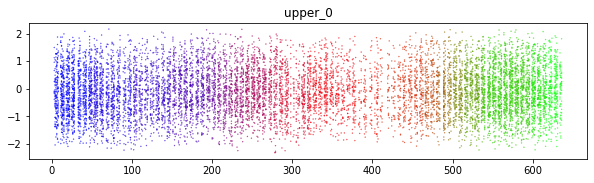

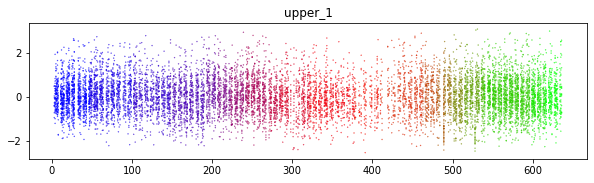

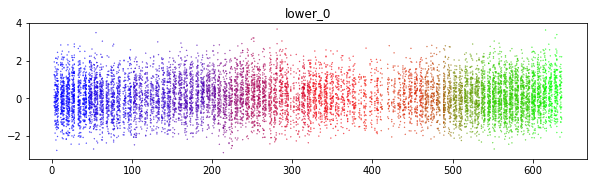

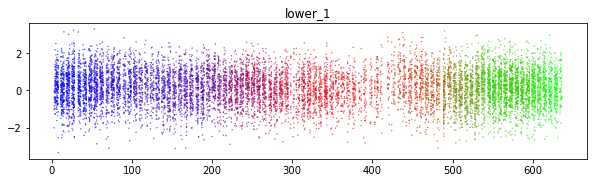

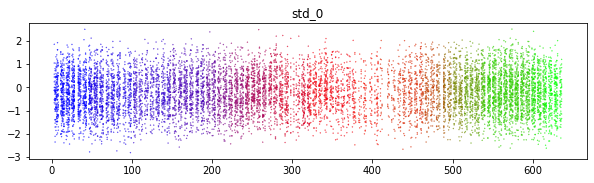

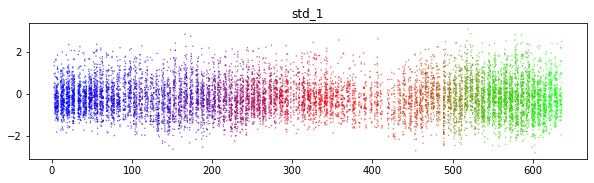

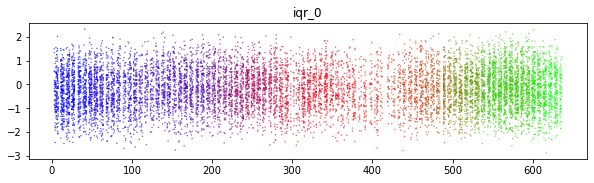

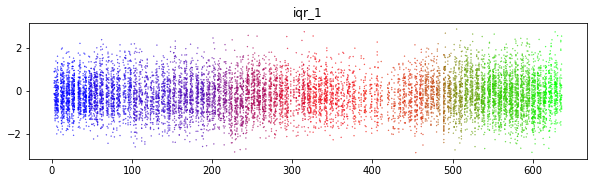

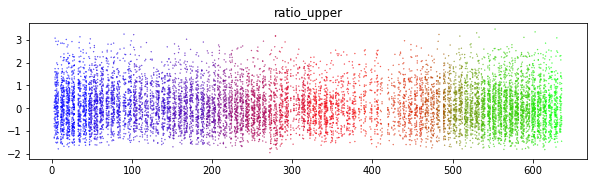

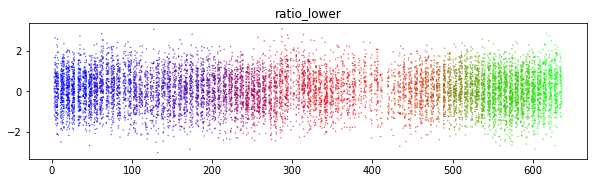

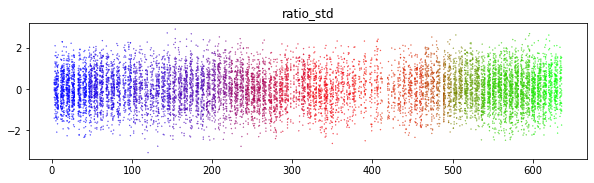

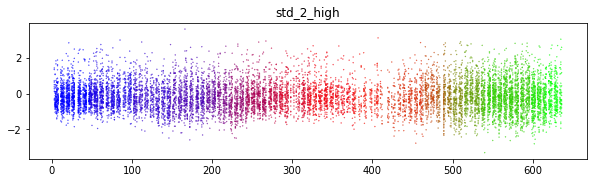

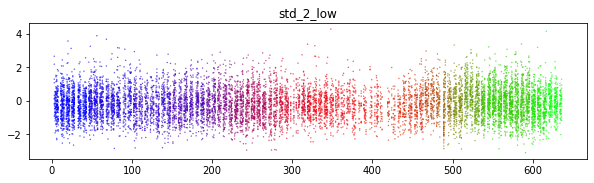

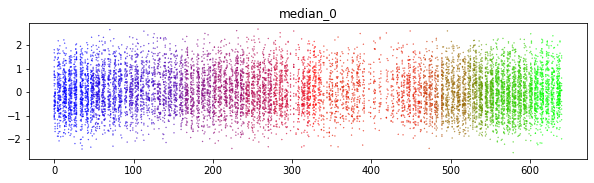

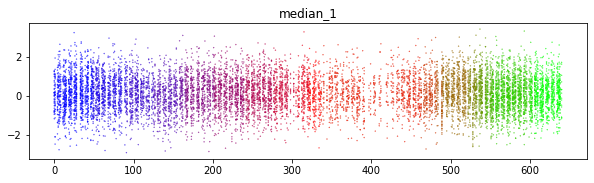

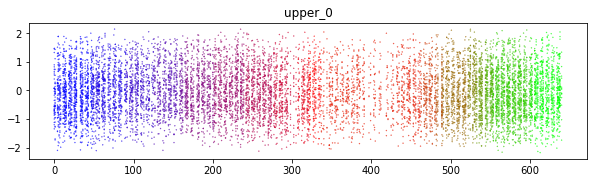

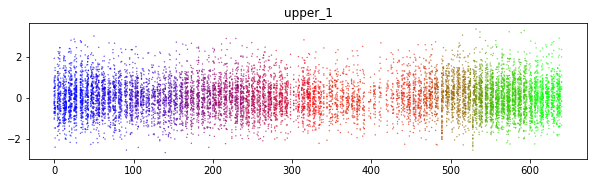

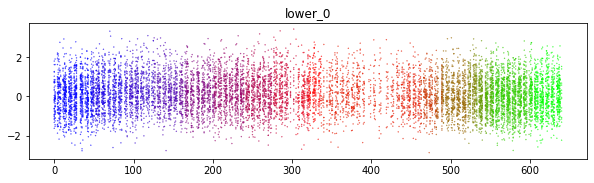

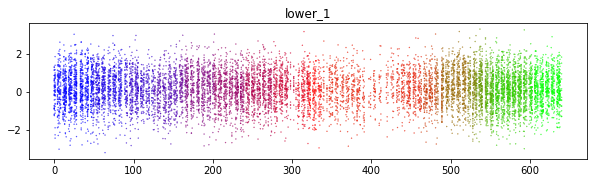

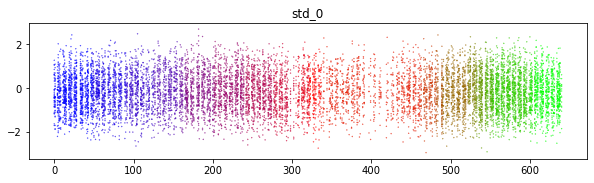

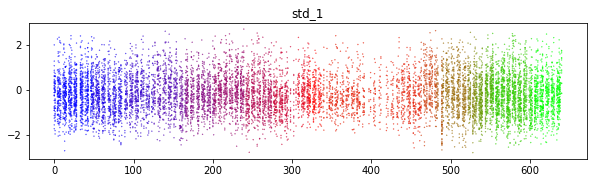

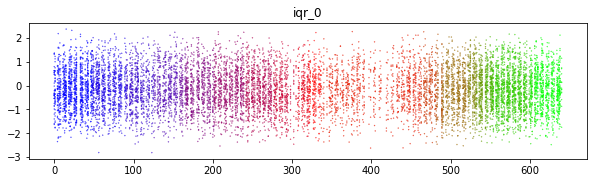

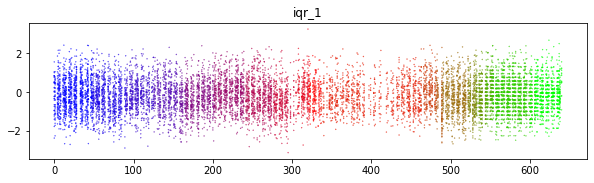

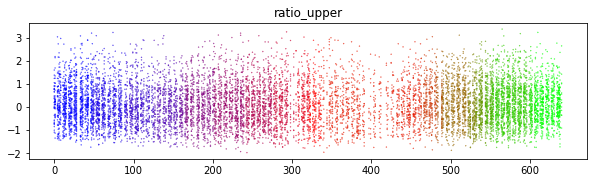

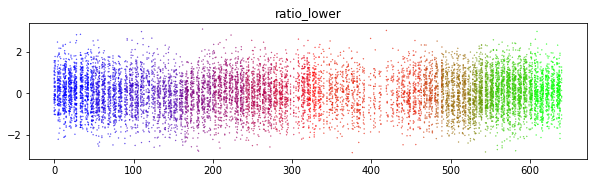

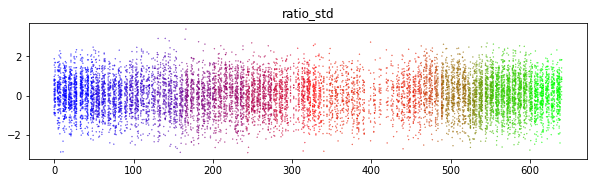

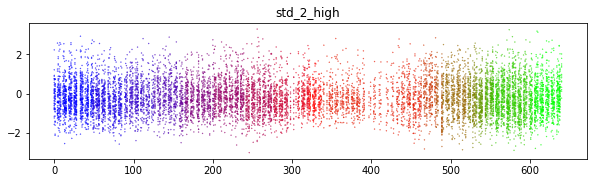

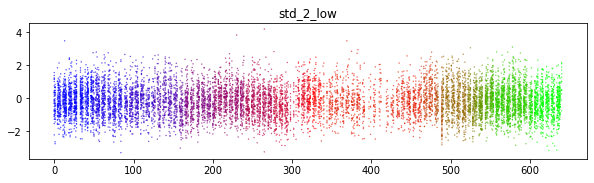

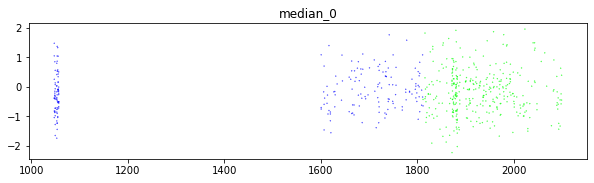

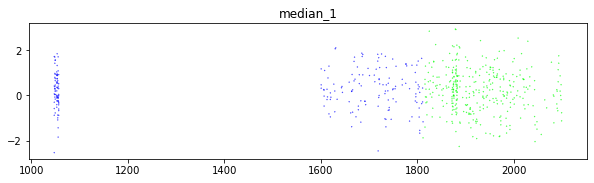

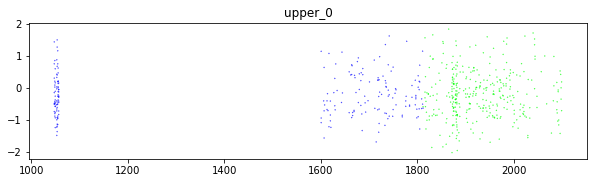

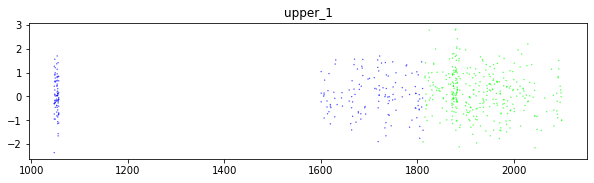

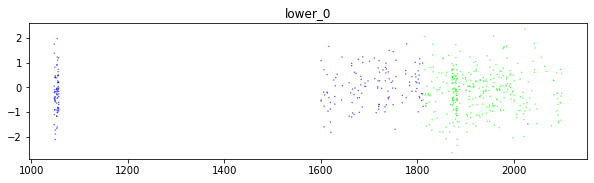

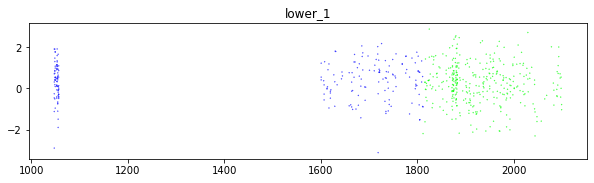

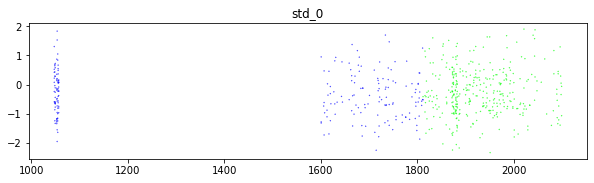

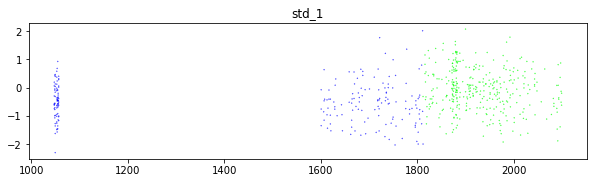

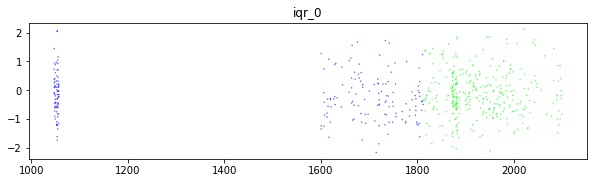

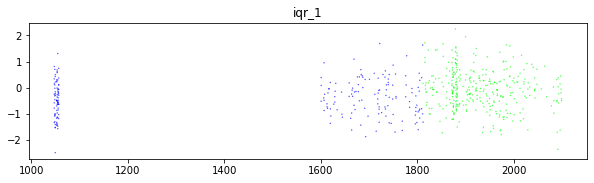

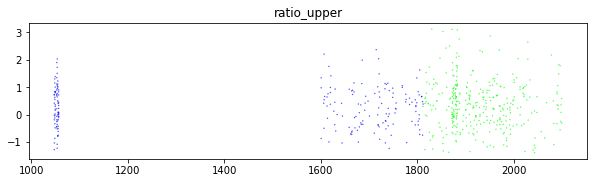

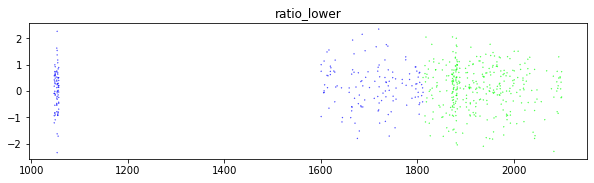

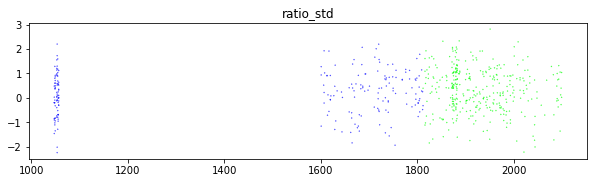

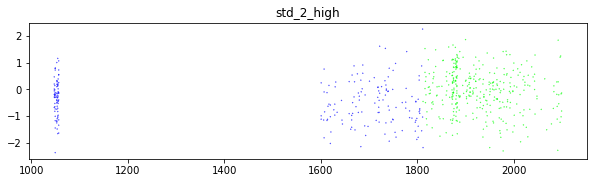

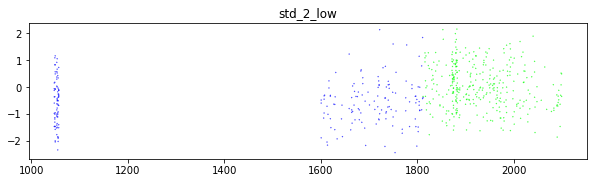

In [36]:
cohort_offset = 0
machines = X_all["Instrument"].unique().tolist()
int_infos = []
for instrument in machines:
    
    X_ = X_all.loc[X_all.Instrument == instrument].copy().sort_values("days_since_start")
    X = X_[features_cols].values
    
    algo_c = rp.KernelCPD(kernel="rbf", min_size=150).fit(
        X
    )
    
    bkps = algo_c.predict(pen=2.3)
    bkps = [0] + bkps
    print("%d BKPS" % len(bkps))

    X_["cohort"] = cohort_offset
    X_["rank"] = np.arange(X_.shape[0])
    for b in bkps[1:]:
        X_.loc[X_["rank"] >= b,"cohort"] += 1
        
    for i in range(X.shape[1]):
        fig = plt.figure(figsize=(10,2.5))
        plt.title(features_cols[i])
        ax = fig.add_subplot(111)
        plt.scatter(X_["days_since_start"],X[:,i],s=.1,c=X_.cohort,cmap="brg")
    int_infos.append(X_)
    cohort_offset = X_.cohort.max() + 1
X_ = pd.concat(int_infos,axis=0)

if not adj_by_cohorts:
    X_["cohort"] = 1

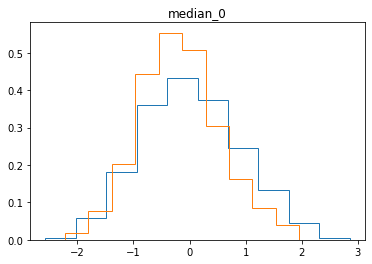

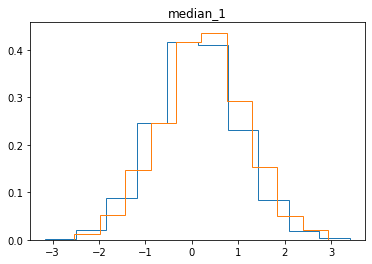

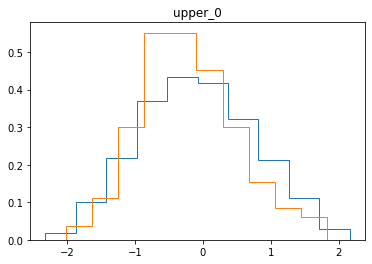

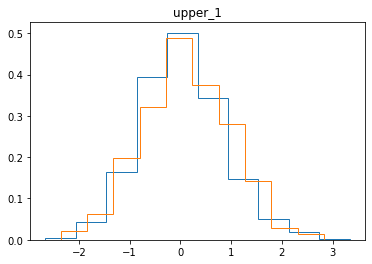

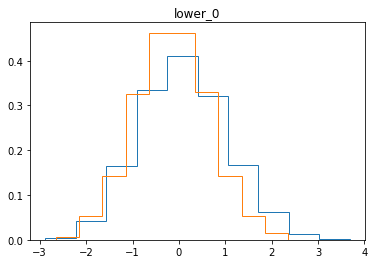

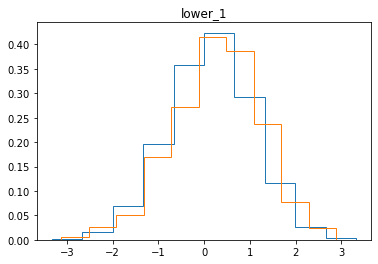

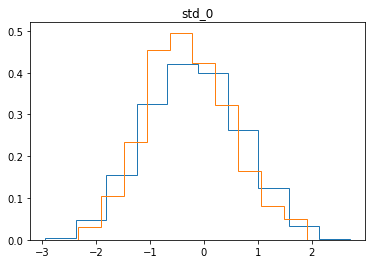

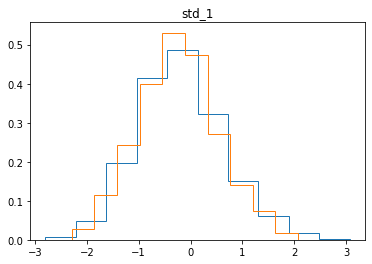

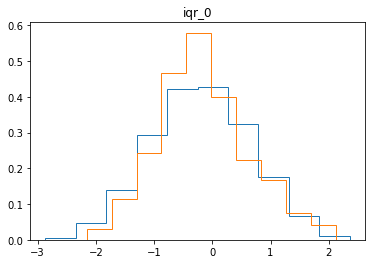

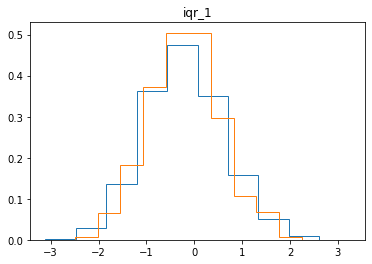

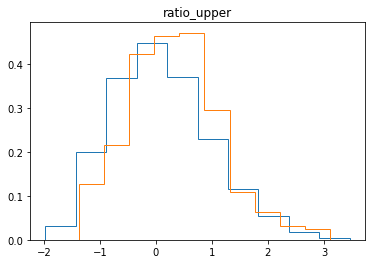

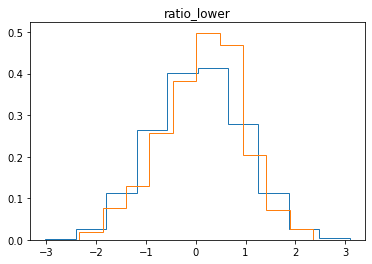

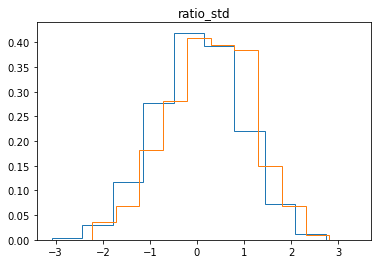

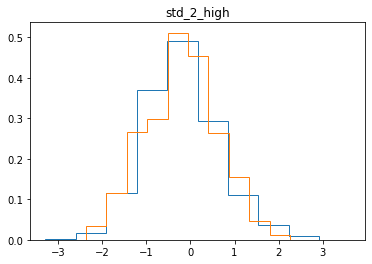

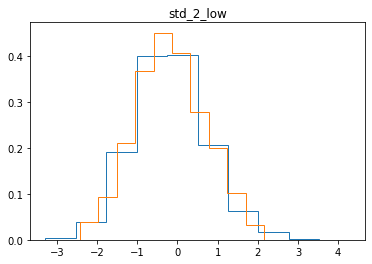

In [37]:
for c in features_cols:
    plt.figure()
    plt.title(c)
    plt.hist(X_all.loc[INT,c],density=True,histtype="step")
    plt.hist(X_all.loc[PFC,c],density=True,histtype="step")

In [38]:
Q_train_adj = correlate(X_all.loc[PFC], features_cols,features_cols)
Q_int_adj =   correlate(X_all.loc[INT], features_cols,features_cols)

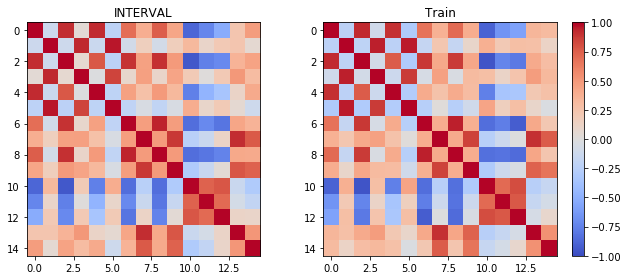

In [39]:
plot_args = {"cmap":"coolwarm","vmin":-1,"vmax":1}
fig = plt.figure(figsize=(9.3,4))
ax = fig.add_subplot(121)
ax.imshow(Q_int_adj,**plot_args)
ax.set_title("INTERVAL")
ax = fig.add_subplot(122)
cm  = ax.imshow(Q_train_adj,**plot_args)
ax.set_title("Train")
plt.colorbar(cm)
plt.tight_layout()

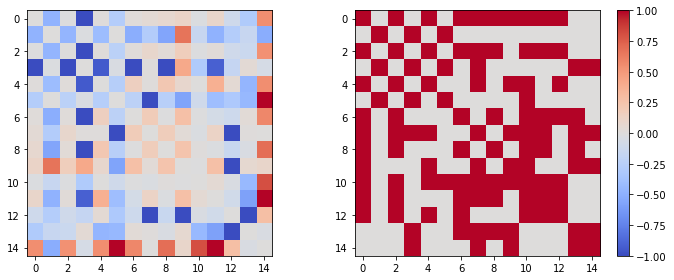

In [40]:
difference = Q_int_adj/Q_train_adj-1
OK = np.abs(difference) <= 0.12

plot_args = {"cmap":"coolwarm","vmin":-1,"vmax":1}
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
ax.imshow(difference,**plot_args)
ax = fig.add_subplot(122)
ax.imshow(OK,**plot_args)
plt.colorbar(cm)
plt.tight_layout()

In [41]:
#good_cross_correlation_cols = OK.loc[np.sum(1*OK,axis=0) > OK.shape[0]/3].index.tolist()
#print(good_cross_correlation_cols)

In [42]:
#good_cols = [c for c in features_cols if "_0" in c]

In [43]:
from sklearn.cross_decomposition import CCA
# linear combination of phenotypes at best predicted by features
features_cca = features_cols
phenos_cca = [c for c in pheno_cols if "PSEL" in c or "FIB" in c]

cc = CCA(n_components=1,scale=True)

all_available = (~X_all[pheno_cols].isnull()).min(axis=1)
print(all_available.sum())

X_cca = X_all.loc[all_available,features_cca].values
Y_cca = X_all.loc[all_available,phenos_cca].values
Y_cca -= np.mean(Y_cca,axis=0)
Y_cca /= np.std(Y_cca,axis=0)

x_scores, y_scores = cc.fit_transform(X_cca,Y_cca)

X_all["CCA"] = np.nan
X_all.loc[all_available,"CCA"] = y_scores

433


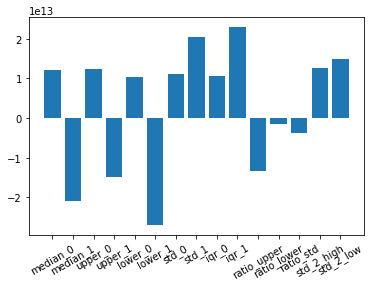

In [44]:
plt.bar(np.arange(cc.x_loadings_.shape[0]),cc.x_loadings_[:,0])
plt.xticks(np.arange(cc.x_loadings_.shape[0]),features_cols,rotation=30);

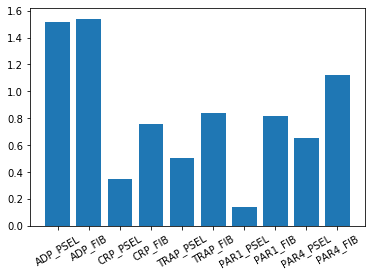

In [45]:
plt.bar(np.arange(cc.y_loadings_.shape[0]),cc.y_loadings_[:,0])
plt.xticks(np.arange(cc.y_loadings_.shape[0]),phenos_cca,rotation=30);

# Estimate performance

In [46]:
#features_cols = ["lower_0","median_0","mean_0"]
#features_cols = features.columns
#features_cols = good_cols
print("After adjustment # 2")
print("CCA")
test_correlation_w_features(X_all,"CCA")
print("ADP")
test_correlation_w_features(X_all,"ADP")


After adjustment # 2
CCA
433 donors
median_0   		 0.16	 0.03 	 5.85e-04
median_1   		 -0.27	 0.07 	 1.83e-08
upper_0   		 0.17	 0.03 	 3.24e-04
upper_1   		 -0.18	 0.03 	 1.49e-04
lower_0   		 0.13	 0.02 	 8.26e-03
lower_1   		 -0.34	 0.12 	 2.33e-13
std_0   		 0.16	 0.03 	 8.03e-04
std_1   		 0.28	 0.08 	 4.46e-09
iqr_0   		 0.16	 0.03 	 8.30e-04
iqr_1   		 0.30	 0.09 	 2.14e-10
ratio_upper   		 -0.18	 0.03 	 1.68e-04
ratio_lower   		 -0.05	 0.00 	 3.29e-01
ratio_std   		 -0.06	 0.00 	 2.15e-01
std_2_high   		 0.18	 0.03 	 1.36e-04
std_2_low   		 0.20	 0.04 	 2.02e-05
ADP
467 donors
median_0   		 0.15	 0.02 	 1.56e-03
median_1   		 -0.24	 0.06 	 1.02e-07
upper_0   		 0.14	 0.02 	 2.11e-03
upper_1   		 -0.18	 0.03 	 8.15e-05
lower_0   		 0.15	 0.02 	 1.55e-03
lower_1   		 -0.31	 0.10 	 3.74e-12
std_0   		 0.12	 0.01 	 8.59e-03
std_1   		 0.21	 0.05 	 3.41e-06
iqr_0   		 0.10	 0.01 	 2.95e-02
iqr_1   		 0.25	 0.06 	 5.52e-08
ratio_upper   		 -0.17	 0.03 	 3.06e-04
ratio_lower   		 0.02	

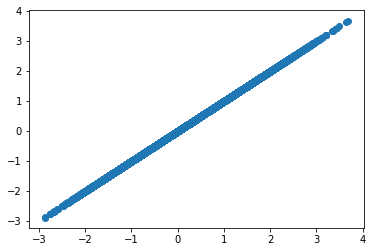

In [47]:
plt.scatter(X_all["lower_0"],X_all["lower_0_unadjusted"])

In [48]:
N_PLS_COMPS = 1

In [49]:
learn_adjuster = False
use_pls = False

In [50]:
from sklearn.linear_model import Lasso

In [51]:
alpha = .01

In [53]:
# .27 with all features + MPV + PLT

In [54]:
features_and_covariates = list(features_cols) + list(covar_cols_for_adj)

In [55]:
pheno_cols = ["ADP"]

In [56]:
alpha_values = [.00001,.00003,.0001,.0003,.001,.005,.01,.02,.05,.1,.3,1.]

In [72]:
rho_cov = defaultdict(lambda: [])
rho_all = defaultdict(lambda: [])
y_pred_test = {}
y_test = {}
r2_res = {}
n_features = {}
features = {}
for alpha in tqdm(alpha_values):
    r2_res[alpha] = []
    n_features[alpha] = []
    features[alpha] = []
    for c in pheno_cols:
        skf = RepeatedStratifiedKFold(n_splits=4,n_repeats=100)
        y = X_all[c]
        cond = ~y.isnull()
        X = X_all.loc[cond,features_and_covariates]
        y = y.loc[cond]

        y_split = pd.cut(y,5,labels=False)

        for i, (train_index, test_index) in enumerate(skf.split(np.zeros(len(y_split)), y_split)):
            pls_res = Lasso(alpha=alpha)
            pls_res.fit(X.iloc[train_index],y.iloc[train_index])
            y_res = np.reshape(pls_res.predict(X),(-1,1))
            y_pred = y_res

            pearson_all = pearsonr(y.iloc[test_index],y_pred[test_index,0])[0]

            r2_res[alpha].append(r2_score(y.iloc[test_index],y_res[test_index,0]))
            n_features[alpha].append(np.sum(pls_res.coef_ != 0))
            features[alpha].append(pls_res.coef_)
            if i == 0:

                y_pred_test[c] = y_pred[test_index,0]
                y_test[c] = y.iloc[test_index]
        

100%|██████████| 12/12 [00:28<00:00,  2.41s/it]


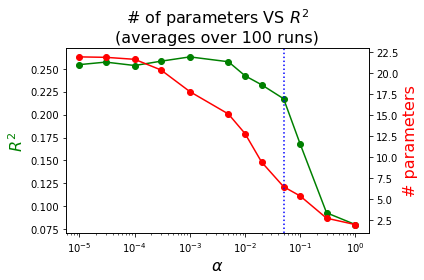

In [86]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
ax.plot(alpha_values,[np.mean(r2_res[alpha]) for alpha in alpha_values],"-o",c="green")
ax.set_xscale("log")
ax.set_ylabel("$R^2$",color="green",fontsize=16)
plt.xlabel("$\\alpha$",fontsize=16)
ax2 = ax.twinx()
plt.plot(alpha_values,[np.mean(n_features[alpha]) for alpha in alpha_values],"-o",c="red")
ax2.set_ylabel("# parameters",color="red",fontsize=16)
ax2.axvline(.05,ls=":",c="blue")
plt.title("# of parameters VS $R^2$\n(averages over 100 runs)",fontsize=16)
plt.tight_layout()
plt.savefig("/home/hv270/sysmex2pf/figures/n_parameters.pdf")

In [87]:
alpha_optimal = .05

In [88]:
features_used = np.stack(features[alpha_optimal],axis=0)

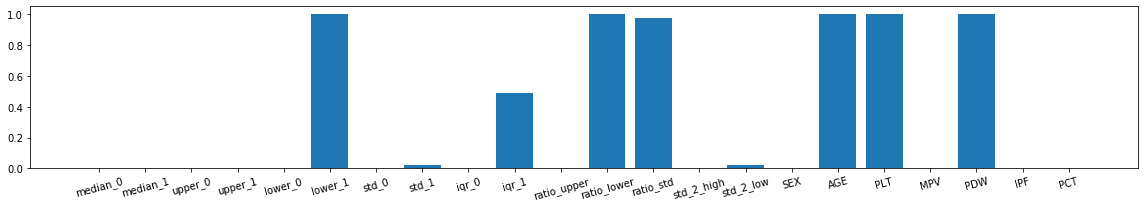

In [89]:
plt.figure(figsize=(16,3))
plt.bar(np.arange(features_used.shape[1]),np.mean(features_used != 0,axis=0))
plt.xticks(np.arange(features_used.shape[1]),features_and_covariates,rotation=15);
plt.tight_layout()
plt.savefig("/home/hv270/sysmex2pf/figures/used_parameters.pdf")

In [303]:
final_features_index = list(np.where(np.mean(features_used != 0,axis=0) > .3)[0])

In [304]:
final_features = [features_and_covariates[i] for i in final_features_index]

In [305]:
final_features

['lower_1', 'iqr_1', 'ratio_lower', 'ratio_std', 'AGE', 'PLT', 'PDW']

In [311]:
rho_cov = defaultdict(lambda: [])
rho_all = defaultdict(lambda: [])
y_pred_test = {}
y_test = {}
r2_res = {}
n_features = {}
features = {}

alpha = alpha_optimal

r2_res[alpha] = []
n_features[alpha] = []
features[alpha] = []
for c in pheno_cols:
    skf = RepeatedStratifiedKFold(n_splits=4,n_repeats=10)
    y = X_all[c]
    cond = ~y.isnull()
    X = X_all.loc[cond,final_features]
    y = y.loc[cond]

    y_split = pd.cut(y,5,labels=False)

    for i, (train_index, test_index) in enumerate(skf.split(np.zeros(len(y_split)), y_split)):
        #pls_res = Lasso(alpha=alpha)
        plt_res = LinearRegression()
        pls_res.fit(X.iloc[train_index],y.iloc[train_index])
        y_res = np.reshape(pls_res.predict(X),(-1,1))
        y_pred = y_res

        pearson_all = pearsonr(y.iloc[test_index],y_pred[test_index,0])[0]

        r2_res[alpha].append(r2_score(y.iloc[test_index],y_res[test_index,0]))
        n_features[alpha].append(np.sum(pls_res.coef_ != 0))
        features[alpha].append(pls_res.coef_)
        if i == 0:

            y_pred_test[c] = y_pred[test_index,0]
            y_test[c] = y.iloc[test_index]


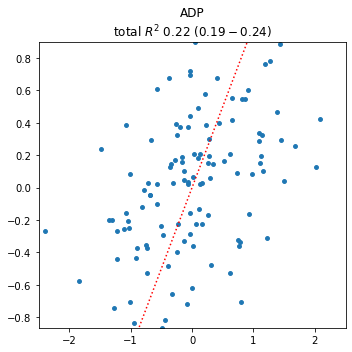

In [312]:
from sklearn.metrics import r2_score
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.scatter(y_test[c],y_pred_test[c],s=15)

ax.set_xlim((-2.5,2.5))
ax.plot([-1.5,1.5],[-1.5,1.5],c="red",ls=":")
ax.set_ylim((np.min(y_pred_test[c]),np.max(y_pred_test[c])))
#R2 = r2_score(y_test[c],y_pred_test[c])

#R2 = (np.quantile(r2_all[c],0.25),np.quantile(r2_all[c],0.5),np.quantile(r2_all[c],0.75))
R2_res = (np.quantile(r2_res[alpha_optimal],0.25),np.quantile(r2_res[alpha_optimal],0.50),np.quantile(r2_res[alpha_optimal],0.75))
#R2_cov = (np.quantile(r2_res[c],0.25),np.quantile(r2_cov[c],0.50),np.quantile(r2_cov[c],0.75))
ax.set_title("%s\ntotal $R^2$ %.2f ($%.2f - %.2f$)" % (c,R2_res[1],R2_res[0],R2_res[2]))
plt.tight_layout()
#plt.savefig("%s/predictions_test.pdf" % export_folder)

# Fit on whole dataset

In [313]:
adjuster = {}
pls_res = {}

predictions = pd.DataFrame(index=X_all.index)

for c in pheno_cols:
    y = X_all[c]
    cond = ~y.isnull()
    #cond = all_available
    X = X_all.loc[cond,final_features]
    y = y.loc[cond]
    pls_res[c] = LinearRegression()
    pls_res[c].fit(X,y)
    y_pred = np.reshape(pls_res[c].predict(X),(-1,1))
    
    predictions[c] = np.nan
    predictions.loc[cond,c] = y_pred[:,0]

In [314]:
pls_res["ADP"].coef_

array([-0.17640532,  0.04003751,  0.26336377,  0.15961744,  0.01184217,
       -0.00254319,  0.2170875 ])

In [315]:
for c in pheno_cols:
    c_cond = ~predictions[c].isnull()
    #c_cond = all_available
    r, p = pearsonr(predictions.loc[c_cond,c],X_all.loc[c_cond,c])
    print("%s : R^2 = %.2f" % (c, r**2))

ADP : R^2 = 0.26


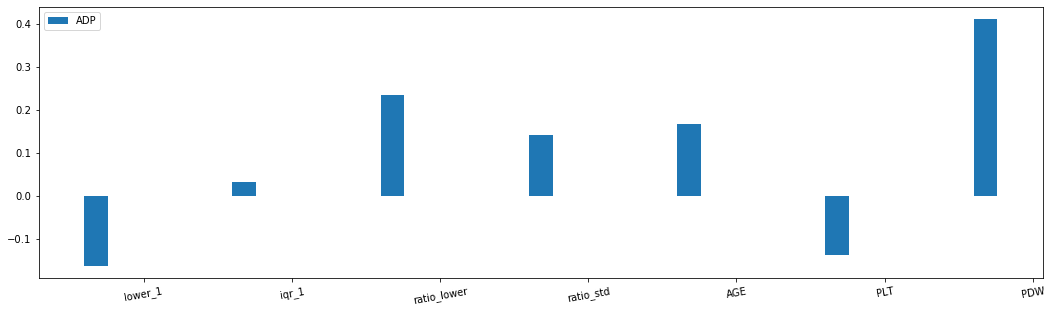

In [320]:
plt.figure(figsize=(18,5))
w = 0.16
for i,c in enumerate([c for c in pheno_cols if "_" not in c]):
    plt.bar(x=np.arange(len(final_features))+w*(i-2),height=np.reshape(pls_res[c].coef_*X_all[final_features].std(axis=0),(-1)),width=w,label=c)
plt.xticks(np.arange(len(final_features)),final_features,rotation=10)
plt.legend();

# Predict on Interval

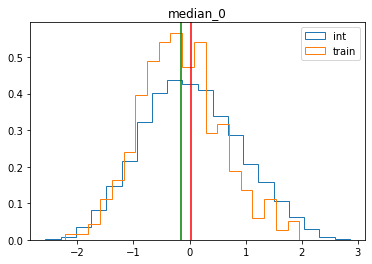

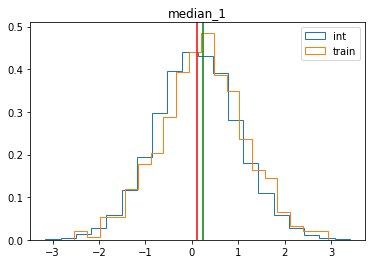

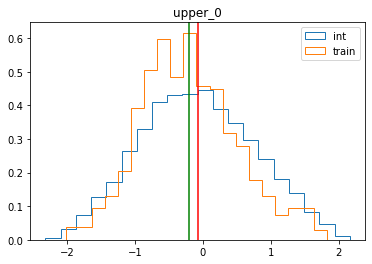

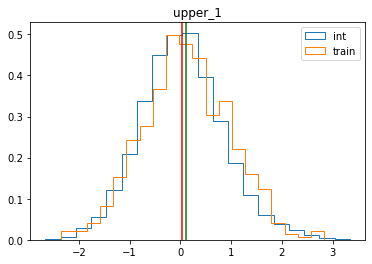

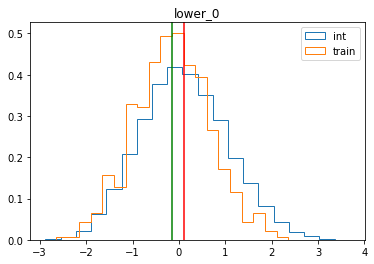

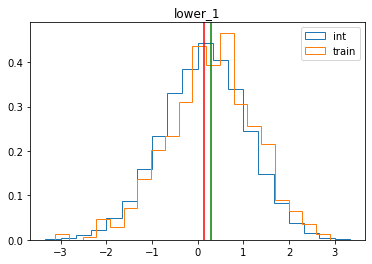

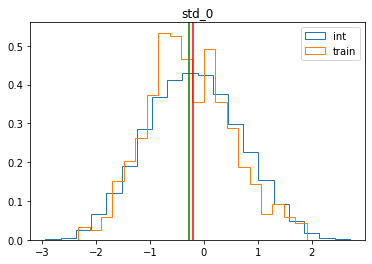

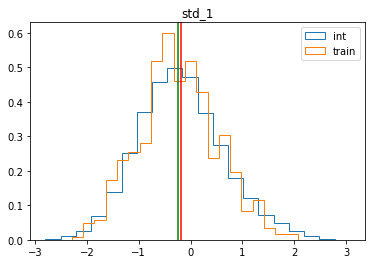

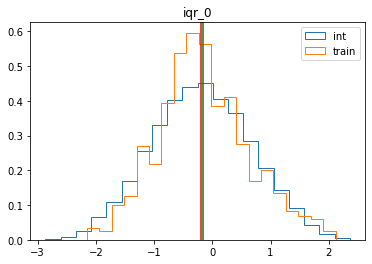

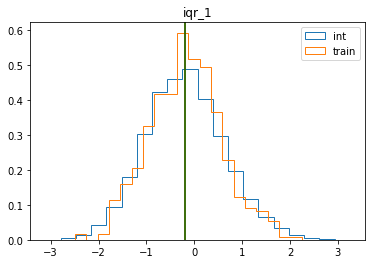

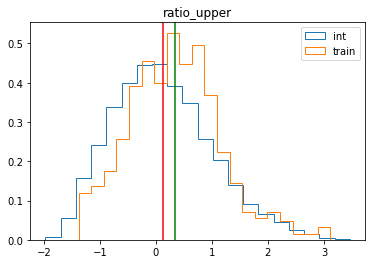

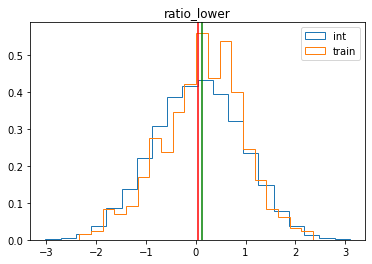

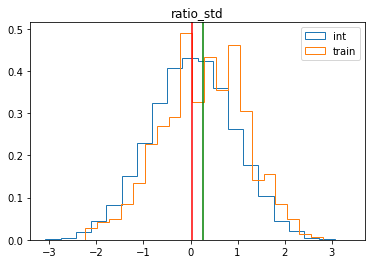

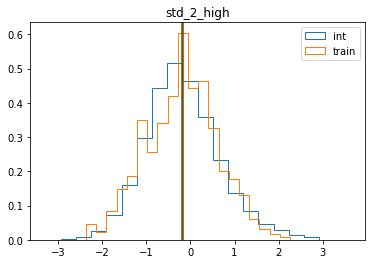

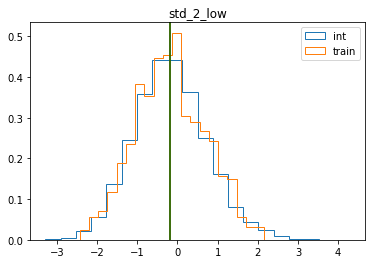

In [321]:
for f in features_cols:
    plt.figure()
    plt.hist(X_all.loc[INT,f],density=True,histtype="step",bins=20,label="int")
    plt.axvline(np.mean(X_all.loc[INT,f]),c="red")
    plt.hist(X_all.loc[PFC,f],density=True,histtype="step",bins=20,label="train")
    plt.axvline(np.mean(X_all.loc[PFC,f]),c="green")
    plt.title(f)
    plt.legend()

In [324]:
#predictions = pd.DataFrame(index=X_all.loc[INT].index)

for c in pheno_cols:
    X = X_all.loc[INT,final_features]
    
    y_pred = np.reshape(pls_res[c].predict(X),(-1,1)) #+ y_cov 
    
    predictions.loc[INT,c] = y_pred[:,0]

In [325]:
predictions = predictions.loc[predictions.isnull().sum(axis=1) == 0]

In [326]:
comp = pd.merge(predictions,X_all,how="left",left_index=True,right_index=True,suffixes=("_pred",""))

In [327]:
comp.columns

Index(['ADP_pred', 'SEX', 'AGE', 'PLT', 'MPV', 'PDW', 'PCT', 'IPF', 'cohort',
       'median_0', 'median_1', 'upper_0', 'upper_1', 'lower_0', 'lower_1',
       'std_0', 'std_1', 'iqr_0', 'iqr_1', 'ratio_upper', 'ratio_lower',
       'ratio_std', 'std_2_high', 'std_2_low', 'machine', 'cohort_all',
       'ADP_PSEL', 'ADP_FIB', 'ADP', 'CRP_PSEL', 'CRP_FIB', 'CRP', 'TRAP_PSEL',
       'TRAP_FIB', 'TRAP', 'PAR1_PSEL', 'PAR1_FIB', 'PAR1', 'PAR4_PSEL',
       'PAR4_FIB', 'PAR4', 'PEAR1', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6',
       'PC7', 'PC8', 'PC9', 'PC10', 'Instrument', 'days_since_start',
       'median_0_unadjusted', 'median_1_unadjusted', 'upper_0_unadjusted',
       'upper_1_unadjusted', 'lower_0_unadjusted', 'lower_1_unadjusted',
       'std_0_unadjusted', 'std_1_unadjusted', 'iqr_0_unadjusted',
       'iqr_1_unadjusted', 'ratio_upper_unadjusted', 'ratio_lower_unadjusted',
       'ratio_std_unadjusted', 'std_2_high_unadjusted', 'std_2_low_unadjusted',
       'CCA', 'AGE_50'],
  

In [328]:
comp.to_csv("%s/processed/predictions.csv" % data_dir)

# Explore association w/ PEAR1

In [165]:
comp = comp.loc[~comp.PEAR1.isnull()]

In [166]:
comp.head()

ADP_PSEL_pred  ADP_FIB_pred  ADP_pred  CRP_PSEL_pred  \
SampleNo                                                                
INT_116_2126200       0.068406      0.046444  0.057173      -0.026792   
INT_116_146000        0.235913      0.259497  0.250601       0.225966   
INT_116_146200        0.046053      0.037994  0.041747       0.049147   
INT_116_148100       -0.111546     -0.133304 -0.123882       0.032188   
INT_116_147900        0.378489      0.437822  0.413988       0.130543   

                 CRP_FIB_pred  CRP_pred  TRAP_PSEL_pred  TRAP_FIB_pred  \
SampleNo                                                                 
INT_116_2126200      0.057795  0.008003        0.030975       0.028683   
INT_116_146000       0.200251  0.214846        0.126539       0.228807   
INT_116_146200       0.055311  0.051164        0.031622       0.070951   
INT_116_148100      -0.080598 -0.018163       -0.013768      -0.075660   
INT_116_147900       0.315335  0.215186        0.121991       0.347360   

                 TRAP_pred  PAR1_PSEL_pred  ...  std_0_unadjusted  \
SampleNo                                    ...                     
INT_116_2126200   0.038138       -0.070007  ...         -0.028706   
INT_116_146000    0.172292        0.099010  ...         -0.067833   
INT_116_146200    0.052943       -0.015826  ...          0.070129   
INT_116_148100   -0.047343        0.044122  ...          0.093913   
INT_116_147900    0.235890       -0.020943  ...          0.053252   

                 std_1_unadjusted  iqr_0_unadjusted  iqr_1_unadjusted  \
SampleNo                                                                
INT_116_2126200          0.012387         -0.020780          0.016312   
INT_116_146000          -0.006756         -0.126743          0.006083   
INT_116_146200           0.017410          0.081525          0.021438   
INT_116_148100           0.010698          0.159784          0.009050   
INT_116_147900           0.035564          0.012383          0.047691   

                 ratio_upper_unadjusted  ratio_lower_unadjusted  \
SampleNo                                                          
INT_116_2126200                0.026438                0.008028   
INT_116_146000                -0.026149                0.022500   
INT_116_146200                -0.102424               -0.011335   
INT_116_148100                -0.146354               -0.035468   
INT_116_147900                 0.012728                0.036825   

                 ratio_std_unadjusted  std_2_high_unadjusted  \
SampleNo                                                       
INT_116_2126200              0.017879              -0.004630   
INT_116_146000               0.011107              -0.008031   
INT_116_146200              -0.003605               0.028288   
INT_116_148100              -0.016030               0.008714   
INT_116_147900               0.016576               0.040537   

                 std_2_low_unadjusted  CCA  
SampleNo                                    
INT_116_2126200              0.047430  NaN  
INT_116_146000              -0.007398  NaN  
INT_116_146200               0.011218  NaN  
INT_116_148100               0.025340  NaN  
INT_116_147900               0.029519  NaN  

[5 rows x 85 columns]

In [167]:
c_INT = comp.index.str.contains("INT")

In [168]:
for c in predictions.columns:
    if "%s_pred" % c not in comp.columns: continue
    
    lm = LinearRegression()
    lm.fit(comp.loc[c_INT,covar_cols],comp.loc[c_INT,"%s_pred" % c])
    comp.loc[c_INT,"%s_adj" % c] = comp.loc[c_INT,"%s_pred" % c] - lm.predict(comp.loc[c_INT,covar_cols])

In [169]:
def get_corr(X,col1,col2):
    cond = ~(X[col1].isnull() | X[col2].isnull())
    return pearsonr(X.loc[cond,col1],X.loc[cond,col2])

In [170]:
get_corr(comp.loc[comp.index.str.contains("INT")],"ADP_FIB_adj","PEAR1")

(-0.026620774489717173, 3.5025632357926375e-05)

In [171]:
get_corr(comp.loc[~comp.index.str.contains("INT")],"ADP_pred","PEAR1")

(-0.08152499835502552, 0.3660877435208573)

In [172]:
get_corr(comp.loc[comp.index.str.contains("INT")],"CCA_adj","PEAR1")

(-0.0025566583248217154, 0.6911099136096874)

In [173]:
def get_gwas(X):
    dic = {}
    for f in comp.columns:
        cond = ~X[f].isnull()
        if cond.sum() < 3: continue
        dic[f] = pearsonr(X.loc[cond,f],X.loc[cond,"PEAR1"])[0]
    return pd.DataFrame.from_dict(dic,orient="index").T

In [174]:
for f in features_cols:
    print(f)
    print(pearsonr(X_all.loc[~X_all.PEAR1.isnull(),f],
         X_all.loc[~X_all.PEAR1.isnull(),"PEAR1"]))

median_0
(0.051543319319264036, 9.076231654623413e-16)
iqr_0
(0.0061245555295843, 0.33979737973074325)
median_1
(0.012272044311823577, 0.05577881065525705)
iqr_1
(-0.008151020007616331, 0.2039360860796374)


In [175]:
# Collider bias

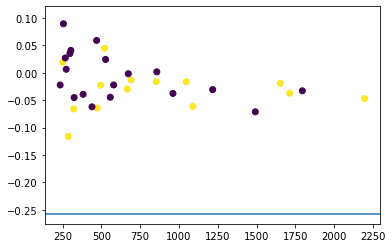

In [176]:
plt.scatter(comp.loc[~comp.PEAR1.isnull()].groupby("cohort")["SEX"].count(),
            comp.loc[~comp.PEAR1.isnull()].groupby("cohort").apply(get_gwas)["ADP_adj"],c=comp.groupby("cohort").Instrument.first())
plt.axhline(comp.loc[~comp.PEAR1.isnull()].groupby("cohort").apply(get_gwas)["ADP"].iloc[0])
beta = comp.loc[~comp.PEAR1.isnull()].groupby("cohort").apply(get_gwas)["ADP_adj"]
bad_cohorts = [c[0] for c in beta.loc[beta > 0.05].index.tolist()]
#plt.yscale("log")
#plt.xscale("log")
#plt.ylim((1e-10,1))

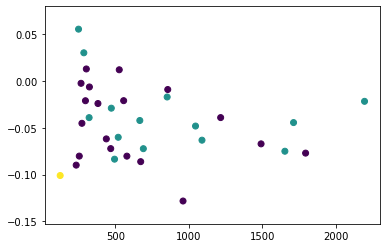

In [177]:
plt.scatter(comp.loc[~comp.PEAR1.isnull()].groupby("cohort")["SEX"].count(),
            comp.loc[~comp.PEAR1.isnull()].groupby("cohort").apply(get_gwas)["MPV"],c=comp.groupby("cohort").Instrument.first())

# Run PLINK just on PEAR1

# Investigate bad cohorts

In [77]:
PLT = pd.read_hdf("%s/processed/PLT.hdf" % data_dir)

In [78]:
bad_IDs = X_all.loc[X_all.cohort.isin(bad_cohorts)].index.tolist()

In [79]:
PLT.head()

ID         FSC        SSC         SFL
0  INT_116_100  116.840937  69.702684  113.287121
1  INT_116_100  125.840937  36.702684   83.287121
2  INT_116_100  111.840937  50.702684   95.287121
3  INT_116_100  113.840937  63.702684  122.287121
4  INT_116_100   58.840937  36.702684   69.287121

In [80]:
wrong_samples = PLT.loc[PLT.ID.isin(bad_IDs)].sample(5000)
good_samples = PLT.loc[~PLT.ID.isin(bad_IDs)].sample(5000)

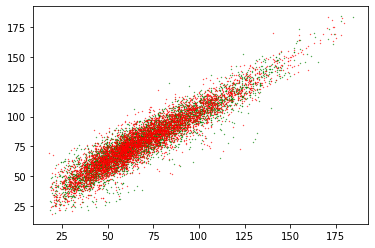

In [84]:
plt.scatter(wrong_samples.FSC,wrong_samples.SFL,s=.1,c="green")
plt.scatter(good_samples.FSC,good_samples.SFL,s=.1,c="red")

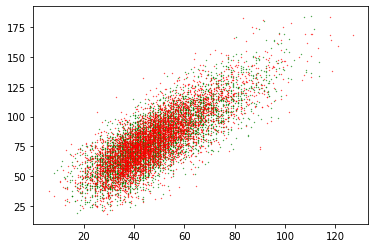

In [85]:
plt.scatter(wrong_samples.SSC,wrong_samples.SFL,s=.1,c="green")
plt.scatter(good_samples.SSC,good_samples.SFL,s=.1,c="red")

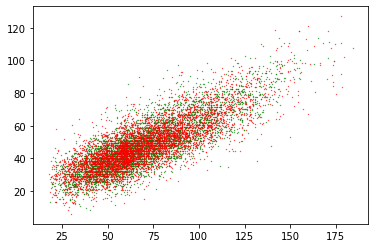

In [87]:
plt.scatter(wrong_samples.FSC,wrong_samples.SSC,s=.1,c="green")
plt.scatter(good_samples.FSC,good_samples.SSC,s=.1,c="red")

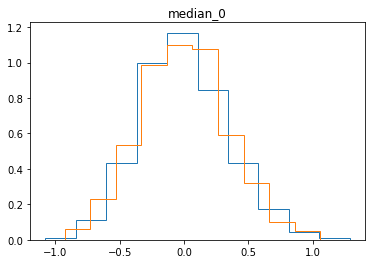

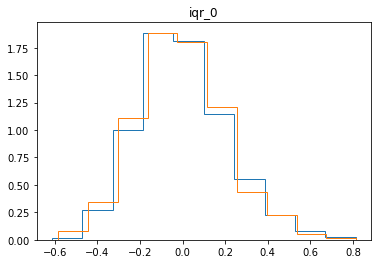

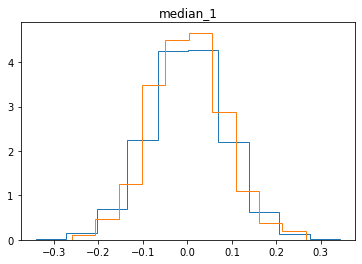

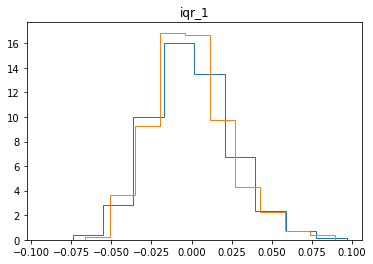

In [89]:
for f in features_cols:
    plt.figure()
    plt.title(f)
    plt.hist(X_all.loc[~X_all.index.isin(bad_IDs),f],density=True,histtype="step")
    plt.hist(X_all.loc[ X_all.index.isin(bad_IDs),f],density=True,histtype="step")

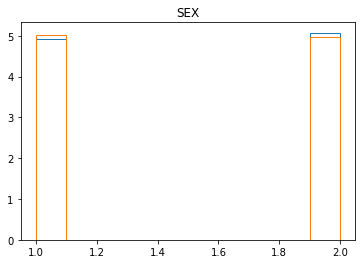

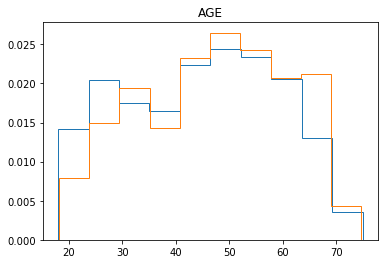

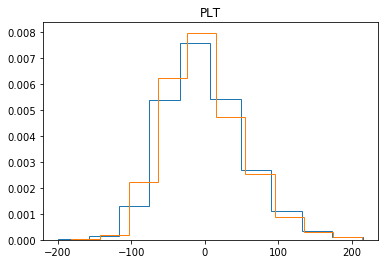

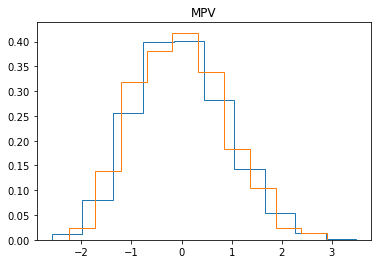

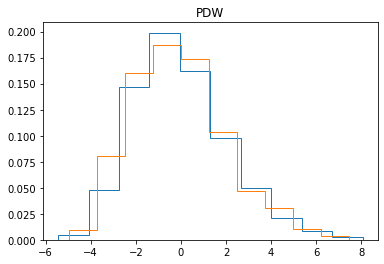

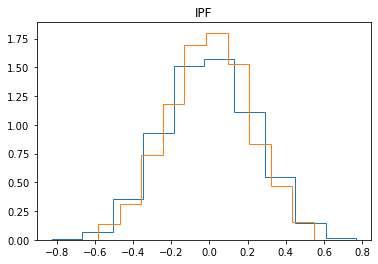

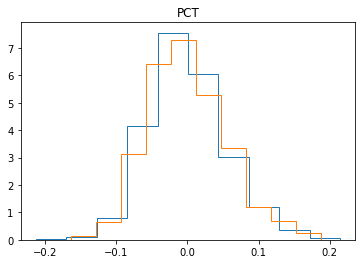

In [90]:
for f in covar_cols:
    plt.figure()
    plt.title(f)
    plt.hist(X_all.loc[~X_all.index.isin(bad_IDs),f],density=True,histtype="step")
    plt.hist(X_all.loc[ X_all.index.isin(bad_IDs),f],density=True,histtype="step")

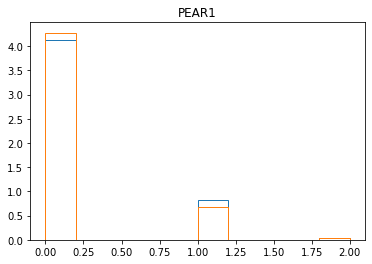

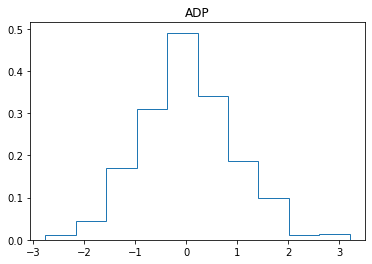

In [96]:
for f in ["PEAR1","ADP"]:
    plt.figure()
    plt.title(f)
    plt.hist(X_all.loc[~X_all.index.isin(bad_IDs) & ~X_all[f].isnull(),f],density=True,histtype="step")
    plt.hist(X_all.loc[ X_all.index.isin(bad_IDs) & ~X_all[f].isnull(),f],density=True,histtype="step")

In [218]:
# Look at top-left corner

In [219]:
cohorts_size = X_all.cohort.value_counts()
small_cohorts = cohorts_size.loc[cohorts_size < 400].index.tolist()

In [221]:
X_all.cohort.isin(bad_cohorts).sum()
X_all.cohort.isin(small_cohorts).sum()

3196

(array([976., 989.,  70.,   0.,   0., 185., 335., 892., 150., 469.]),
 array([145. , 194.1, 243.2, 292.3, 341.4, 390.5, 439.6, 488.7, 537.8,
        586.9, 636. ]),
 <a list of 10 Patch objects>)

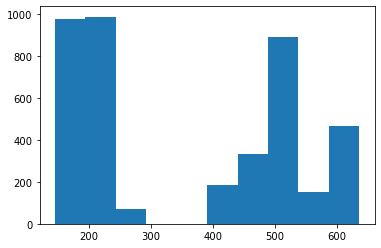

In [222]:
plt.hist(X_all.loc[X_all.cohort.isin(bad_cohorts)].days_since_start)

In [223]:
pearsonr(X_all.loc[INT,"MPV"],X_all.loc[INT,"PEAR1"])

(-0.04987747105169695, 8.459775660012576e-15)

In [228]:
pearsonr(X_all.loc[INT,"lower_0"],X_all.loc[INT,"PEAR1"])

(0.015192747927220508, 0.01815100773272817)

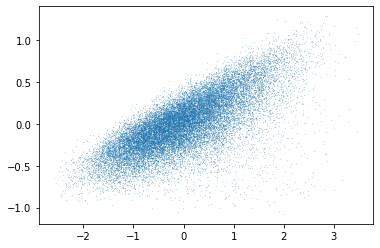

In [225]:
plt.scatter(X_all.loc[INT,"MPV"],X_all.loc[INT,"median_0"],s=.01)

In [232]:
X_all

SEX   AGE        PLT       MPV       PDW       PCT       IPF  \
SampleNo                                                                        
INT_116_2126200    1  20.8 -37.047779  0.079505  0.203081 -0.014295 -0.064832   
INT_116_146000     2  56.4  89.104282 -0.312576 -1.118089  0.096444  0.040020   
INT_116_146200     2  61.5 -29.232347  1.504619  1.928901  0.009321  0.213080   
INT_116_148100     1  55.5  -0.335895  1.181269  2.867554  0.045866  0.278219   
INT_116_147900     1  20.5 -26.442117 -0.417042 -0.688870 -0.024781 -0.020525   
...              ...   ...        ...       ...       ...       ...       ...   
C1A2PI             1  69.0  -6.501594  0.098054  0.636961  0.007133 -0.082923   
C1A2RE             1  60.0 -21.818091  0.533327  1.893891  0.000812 -0.019296   
C1A2TA             2  42.0 -32.438514 -0.580771 -1.360438 -0.052488 -0.303910   
C1A2X2             1  71.0 -44.421939 -0.703475 -1.077545 -0.038820 -0.355055   
C1A32N             2  44.0 -40.317323  0.538976  1.066239 -0.013014  0.072003   

                 cohort  median_0  median_1  ...  std_0_unadjusted  \
SampleNo                                     ...                     
INT_116_2126200      20 -0.176993 -0.090911  ...         -0.028706   
INT_116_146000       20  0.182063 -0.030293  ...         -0.067833   
INT_116_146200       20  0.408441 -0.088320  ...          0.070129   
INT_116_148100       20  0.540536 -0.055763  ...          0.093913   
INT_116_147900       20 -0.204487 -0.019094  ...          0.053252   
...                 ...       ...       ...  ...               ...   
C1A2PI               -1  0.028381  0.031053  ...          0.008433   
C1A2RE               -1  0.203180 -0.063577  ...         -0.009059   
C1A2TA               -1 -0.218105 -0.039509  ...         -0.130645   
C1A2X2               -1 -0.403415  0.093184  ...         -0.114490   
C1A32N               -1  0.070990 -0.072476  ...          0.026486   

                 std_1_unadjusted  iqr_0_unadjusted  iqr_1_unadjusted  \
SampleNo                                                                
INT_116_2126200          0.012387         -0.020780          0.016312   
INT_116_146000          -0.006756         -0.126743          0.006083   
INT_116_146200           0.017410          0.081525          0.021438   
INT_116_148100           0.010698          0.159784          0.009050   
INT_116_147900           0.035564          0.012383          0.047691   
...                           ...               ...               ...   
C1A2PI                  -0.010635         -0.030236          0.008747   
C1A2RE                  -0.000755         -0.064812         -0.002371   
C1A2TA                  -0.007119         -0.178065         -0.011822   
C1A2X2                  -0.004194         -0.186799         -0.003045   
C1A32N                   0.015100          0.027887          0.011571   

                 ratio_upper_unadjusted  ratio_lower_unadjusted  \
SampleNo                                                          
INT_116_2126200                0.026438                0.008028   
INT_116_146000                -0.026149                0.022500   
INT_116_146200                -0.102424               -0.011335   
INT_116_148100                -0.146354               -0.035468   
INT_116_147900                 0.012728                0.036825   
...                                 ...                     ...   
C1A2PI                        -0.016358               -0.025091   
C1A2RE                        -0.056609               -0.004828   
C1A2TA                         0.067428                0.032547   
C1A2X2                         0.173169                0.031678   
C1A32N                        -0.047045                0.013293   

                 ratio_std_unadjusted  std_2_high_unadjusted  \
SampleNo                                                       
INT_116_2126200              0.017879              -0.004630   
INT_116_146000               0.011107 

In [ ]:
predictions.to_csv("%s/processed/predictions.csv" % data_dir)
features.to_csv("%s/processed/features.csv" % data_dir)
X_int_adj[features.columns].to_csv("%s/processed/features_adjusted.csv" % data_dir)
X_all[sysmex_covariates].to_csv("%s/processed/sysmex_features_adjusted.csv"  % data_dir)

In [ ]:
comp = pd.merge(predictions, X_int_adj,left_index=True,right_index=True,how="inner")
plt.scatter(comp.lower_0,comp.CCA)

In [ ]:
raise "The end"